Author: Tyler Chase

Date: 2017/05/18

# Subreddit Classification

This code uses a classification model to classify an image to one of 20 subreddits. For the sake of the milestone we implement an Alex Net model and analyze the results. 

## Wrapper function for building graph

This function reduces the text needed for running the @property wrapper making the code more readable. 

In [1]:
# reduces the text needed for running @property making code more readable
def lazy_property(function):
    # Attribute used to test if code chunk has been run or not
    attribute = '_lazy_' + function.__name__
    # run wrapper function when wrapper returned below
    @property
    # Keeps original function attributes such as function.__name__ 
    # Otherwise it would be replaced with the wrapper attributes
    @functools.wraps(function)
    def wrapper(self):
        # If doesn't have (attribute) then code chunk hasn't been run
        if not hasattr(self, attribute):
            # Run code chunk and store it in (attribute) of class
            setattr(self, attribute, function(self))     
        # return the value of the number stored in (attribute)
        return getattr(self, attribute)
    return wrapper

## Load Datasets

In [2]:
import tensorflow as tf
import numpy as np
import math
import timeit
import random
import pickle
import matplotlib.pyplot as plt
import itertools
import functools
import time
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [3]:
# Load data and split into training validation and testing sets

# Function for permuting and splitting data into training, developement, and test
def import_dataset(address, file_names, train_percent = 80, dev_percent = 10):
    SEED = 455
    random.seed(SEED)
    # Read csv file and create a list of tuples
    images = np.load(address+file_names['images'])
    images = images.astype(float)
    with open(address + file_names['subs'], 'rb') as file_2:
        subs = pickle.load(file_2)
        subs = np.array(subs)
    with open(address + file_names['dict'], 'rb') as file_3:
        dictionary = pickle.load(file_3)
    # Mix data and split into tran, dev, and test sets
    N,W,H,C = np.shape(images)
    indices = np.arange(N)
    random.shuffle(indices)
    images = images[indices]
    subs = subs[indices]
    train_end = int(train_percent*N/100)
    dev_end = train_end + int(dev_percent*N/100)
    X_train = images[:train_end]
    y_train = subs[:train_end]
    X_val = images[train_end:dev_end]
    y_val = subs[train_end:dev_end]
    X_test = images[dev_end:]
    y_test = subs[dev_end:]
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    return X_train, y_train, X_val, y_val, X_test, y_test, dictionary

# Form training, developement, and testing data sets
address = r'/home/tylerchase/CS-231N-Final-Project/data/fullData//'
file_names = {}
file_names['images'] = 'full_data.npy'
file_names['subs'] = 'full_subredditlabels'
file_names['dict'] = 'full_subredditIndex'
X_train, y_train, X_val, y_val, X_test, y_test, dictionary = import_dataset(address, file_names)

# Print the sizes as a sanity check
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Train data shape:  (25450, 128, 128, 3)
Train labels shape:  (25450,)
Validation data shape:  (3181, 128, 128, 3)
Validation labels shape:  (3181,)
Test data shape:  (3182, 128, 128, 3)
Test labels shape:  (3182,)


## Define AlexNet model 

* 11x11 convolutional layer with 96 filters and a stride of 4
* ReLU activation
* 3x3 max pooling with a stride of 2
* batch normalization


* 5x5 convolutional layer with 256 filters and a stride of 1
* ReLU activation
* 3x3 max pooling with a stride of 2
* batch normalization


* 3x3 convolutional layer with 384 filters and a stride of 1
* ReLU activation
* 3x3 convolutional layer with 384 filters and a stride of 1
* ReLU activation 
* 3x3 convolutional layer with 256 filters and a stride of 1
* ReLU activation
* 3x3 max pooling with a stride of 2


* affine layer from 4096 to 1792
* ReLU activation
* affine layer from 1792 to 1792
* ReLU activation
* affine layer from 1792 to 20

In [4]:
# Configuration file storing important values
class Config:
    def __init__(self, sample_size, class_size, image_width, image_height, image_depth):
        self.sample_size = sample_size
        self.class_size = class_size
        self.image_width = image_width
        self.image_height = image_height
        self.image_depth = image_depth

In [5]:
class AlexNet:
    
    def __init__(self, config, learning_rate=0.003):
        self.config = config
        self.data, self.target, self.is_training = self._initialize_placeholders()
        self.learning_rate = learning_rate
        self.prediction
        self.cost
        self.optimize
        self.accuracy
        
    def _initialize_placeholders(self):
        data = tf.placeholder(tf.float32, [None, self.config.image_height, 
                                         self.config.image_width, self.config.image_depth])
        target = tf.placeholder(tf.int64, [None])
        is_training = tf.placeholder(tf.bool)
        return(data, target, is_training)
        
    @lazy_property
    def prediction(self):
        # define our graph (e.g. AlexNet)
        
        a1 = tf.layers.conv2d(self.data, filters=96, kernel_size=(11,11), strides=(4,4), padding='SAME') #Out N/4 x N/4
        h1 = tf.nn.relu(a1)
        mp1 = tf.layers.max_pooling2d(h1, pool_size=(3,3), strides=(2,2), padding='SAME')    #Out N/2 x N/2
        bn1 = tf.layers.batch_normalization(mp1, training=self.is_training)
        
        a2 = tf.layers.conv2d(bn1, filters=256, kernel_size=(5,5), strides=(1,1), padding='SAME')     #Out N x N
        h2 = tf.nn.relu(a2)
        mp2 = tf.layers.max_pooling2d(h2, pool_size=(3,3), strides=(2,2), padding='SAME')    #Out N/2 x N/2
        bn2 = tf.layers.batch_normalization(mp2, training=self.is_training)              
    
        a3 = tf.layers.conv2d(bn2, filters=384, kernel_size=(3,3), strides=(1,1), padding='SAME')     #Out N x N
        h3 = tf.nn.relu(a3)
        a4 = tf.layers.conv2d(h3, filters=384, kernel_size=(3,3), strides=(1,1), padding='SAME')      #Out N x N
        h4 = tf.nn.relu(a4)
        a5 = tf.layers.conv2d(h4, filters=256, kernel_size=(3,3), strides=(1,1), padding='SAME')      #Out N x N
        h5 = tf.nn.relu(a5)
        mp3 = tf.layers.max_pooling2d(h5, pool_size=(3,3), strides=(2,2), padding='SAME')   #Out N/2 x N/2
    
        mp_flat = tf.reshape(mp3,[-1,4096])
        aff1 = tf.layers.dense(mp_flat, 1792)
        h6 = tf.nn.relu(aff1)
        aff2 = tf.layers.dense(h6, 1792)
        h7 = tf.nn.relu(aff2)
        y_out = tf.layers.dense(h7, self.config.class_size)
    
        return y_out        
    
    @lazy_property
    def cost(self):
        target_vec = tf.one_hot(self.target, self.config.class_size)
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=target_vec, logits=self.prediction)
        #cross_entropy = tf.losses.hinge_loss(labels=target_vec, logits=self.prediction)
        cross_entropy_sum = tf.reduce_sum(cross_entropy)
        return cross_entropy_sum
    
    @lazy_property
    def optimize(self):
        opt = tf.train.AdamOptimizer(self.learning_rate)
        #opt = tf.train.GradientDescentOptimizer(self.learning_rate)

        train_step = opt.minimize(self.cost)
        
        # batch normalization in tensorflow requires this extra dependency
        # this is required to update the moving mean and moving variance variables
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(extra_update_ops):
            train_step = opt.minimize(self.cost)
        
        return(train_step)
    
    @lazy_property
    def accuracy(self):
        incorrect = tf.equal(tf.argmax(self.prediction, axis = 1), self.target)
        return tf.reduce_mean( tf.cast(incorrect, tf.float32) )

## Test the Size of Your Output as Sanity Check

Input random numbers into X for feed dictionary and check the size of the output makes sense. 

In [6]:
# minibatch determining training error and accuracy to avoid RAM issues
def train_batch(session, model, x_train, y_train, batch_size, print_batch = False):
    # Loop over minibatches
    cost = 0
    correct = 0
    sample_size = np.shape(x_train)[0]
    for j,i in enumerate(np.arange(0, sample_size, batch_size)):
        batch_x = x_train[i:i+batch_size,:,:,:]
        batch_y = y_train[i:i+batch_size]
        variables = [model.cost, model.accuracy]
        cost_i, accuracy_i = session.run(variables, \
            {model.data:batch_x, model.target:batch_y, model.is_training:False})
        num_sampled = np.shape(batch_x)[0]
        cost += cost_i
        correct += accuracy_i*num_sampled
        if print_batch:
            # print run time, current batch, and current epoch
            print("Batch {:d}/{:d}".format(j+1, int(round(sample_size/batch_size))) )
            print("cost: ", cost_i)
            print("accuracy: ", accuracy_i)
            print("num_sampled: ", num_sampled)
            print()
    accuracy = np.float(correct/sample_size)
    
    return cost, accuracy 
            

In [7]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
config = Config(sample_size=100, class_size=20, image_height=128, image_width=128, image_depth=3)
x = np.random.randn(config.sample_size, config.image_height, config.image_width, config.image_depth)
y = np.random.randn(config.sample_size)
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"

        model = AlexNet(config, learning_rate=0.003)
        
        tf.global_variables_initializer().run()
        variables = [model.prediction, model.cost, model.accuracy]
        ans_rnd, cost_rnd, acc_rnd = sess.run(variables,feed_dict={model.data:x, model.target:y, model.is_training:False})
        cost, acc = train_batch(sess, model, X_train, y_train, batch_size = 2000, print_batch=True)
        #ans, cost, acc = sess.run(variables,feed_dict={model.data:X_train, model.target:y_train, model.is_training:False})
       
        print('random data')
        print('prediction shape: ',ans_rnd.shape)
        print(np.array_equal(ans_rnd.shape, np.array([100, 20])))
        print('cost: ', cost_rnd)
        print('accuracy: ', acc_rnd)
        print('\ntraining data')
        print('cost: ', cost)
        print('accuracy: ', acc)

Batch 1/13
cost:  16362.0
accuracy:  0.052
num_sampled:  2000

Batch 2/13
cost:  16698.9
accuracy:  0.047
num_sampled:  2000

Batch 3/13
cost:  16218.2
accuracy:  0.0475
num_sampled:  2000

Batch 4/13
cost:  16535.1
accuracy:  0.044
num_sampled:  2000

Batch 5/13
cost:  16504.9
accuracy:  0.0435
num_sampled:  2000

Batch 6/13
cost:  16545.8
accuracy:  0.049
num_sampled:  2000

Batch 7/13
cost:  16026.7
accuracy:  0.0535
num_sampled:  2000

Batch 8/13
cost:  16335.0
accuracy:  0.0535
num_sampled:  2000

Batch 9/13
cost:  16786.7
accuracy:  0.0445
num_sampled:  2000

Batch 10/13
cost:  16192.6
accuracy:  0.048
num_sampled:  2000

Batch 11/13
cost:  16574.2
accuracy:  0.053
num_sampled:  2000

Batch 12/13
cost:  16905.8
accuracy:  0.0425
num_sampled:  2000

Batch 13/13
cost:  11459.6
accuracy:  0.0655172
num_sampled:  1450

random data
prediction shape:  (100, 20)
True
cost:  245.034
accuracy:  0.0

training data
cost:  209145.527344
accuracy:  0.04915520600052386


## Train the Model

In [8]:
# Data class for run
class Data:
    def __init__(self, X_train, Y_train, X_val, Y_val, X_test, Y_test):
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_val = X_val
        self.Y_val = Y_val
        self.X_test = X_test
        self.Y_test = Y_test

In [33]:
# Function for running model
class Run:
    
    def __init__(self, session, config, data, model, epoch_size=15, minibatch_size = 100, 
                 learning_rate = 0.003, save_flag = False, print_every = 100, saver_address=''):
        self.session = session 
        self.config = config
        self.data = data
        self.model = model
        self.epoch_size = epoch_size
        self.minibatch_size = minibatch_size
        self.learning_rate = learning_rate
        self.save_flag = save_flag
        self.print_every = print_every
        self.saver_address = saver_address
        self.loader_address = loader_address
        self._train_loss_hist = []
        self._val_loss_hist = []
        self._train_acc_hist = []
        self._val_acc_hist = []
        
    def train(self):
        
        # Save model parameters
        if self.save_flag == True:    
            saver = tf.train.Saver()
            
        self.session.run( tf.global_variables_initializer() )
        
        # Loop over epochs
        for epoch in range(self.epoch_size):
            startTime_epoch = time.clock()
            startTime_batch = time.clock()
            
            # Loop over minibatches
            for j,i in enumerate(np.arange(0, self.config.sample_size, self.minibatch_size)):
                batch_x = self.data.X_train[i:i+self.minibatch_size,:,:,:]
                batch_y = self.data.Y_train[i:i+self.minibatch_size]
                self.session.run(self.model.optimize, 
                                 {self.model.data:batch_x, self.model.target:batch_y, self.model.is_training:True})
                
                # print run time, current batch, and current epoch
                if not j%self.print_every:
                    batch_time = time.clock() - startTime_batch
                    startTime_batch = time.clock()
                    print("Batch {:d}/{:d} of epoch {:d} finished in {:f} seconds".format(j+1,  \
                        int(round(self.config.sample_size/self.minibatch_size)), (epoch+1), batch_time))
             
            # Print current output, return losses, and return accuracies
            epoch_time = time.clock() - startTime_epoch
            print("Epoch {:d} finished in {:f} seconds".format( (epoch + 1), epoch_time))
            variables = [self.model.cost, self.model.accuracy]
            loss_train, acc_train = train_batch(session, model, self.data.X_train, self.data.Y_train, batch_size = 2000)
            loss_val, acc_val = self.session.run(variables, \
                {self.model.data:self.data.X_val, self.model.target:self.data.Y_val, self.model.is_training:False})
            print('Epoch:{:2d}, Training Accuracy {:3.1f}%, Vallidation Accuracy:{:3.1f}%'.format( \
                (epoch + 1), (100*acc_train), (100*acc_val)))
            
            # Append losses and accuracies to list
            self._train_loss_hist.append(loss_train)
            self._val_loss_hist.append(loss_val)
            self._train_acc_hist.append(acc_train)
            self._val_acc_hist.append(acc_val)
            
        # Save model
        if self.save_flag == True: 
            # Save trained model to data folder
            saver.save(self.session, self.saver_address + 'classification_model')      
            
    def return_loss_acc(self):
        return self._train_loss_hist, self._val_loss_hist, self._train_acc_hist, self._val_acc_hist

In [10]:
# Generate Config instance
config = Config(sample_size=np.shape(X_train)[0], class_size=20, image_height=128, image_width=128, image_depth=3)

# Generate Data instance
data = Data(X_train, y_train, X_val, y_val, X_test, y_test)

In [27]:
# Create model instance
tf.reset_default_graph()
model = AlexNet(config, learning_rate = 0.003)
# Create run instance
session = tf.Session()
run = Run(session, config, data, model, epoch_size=15, learning_rate=0.003, print_every = 100, minibatch_size=100,
         saver_address=r'/home/tylerchase/CS-231N-Final-Project/src/subreddit_classification_parameters/', 
         save_flag=True)
run.train()

Batch 1/254 of epoch 1 finished in 0.311993 seconds
Batch 101/254 of epoch 1 finished in 17.761111 seconds
Batch 201/254 of epoch 1 finished in 17.793445 seconds
Epoch 1 finished in 45.420213 seconds
Epoch: 1, Training Accuracy 21.9%, Vallidation Accuracy:21.9%
Batch 1/254 of epoch 2 finished in 0.193563 seconds
Batch 101/254 of epoch 2 finished in 17.911280 seconds
Batch 201/254 of epoch 2 finished in 17.871456 seconds
Epoch 2 finished in 45.531009 seconds
Epoch: 2, Training Accuracy 26.3%, Vallidation Accuracy:26.3%
Batch 1/254 of epoch 3 finished in 0.191401 seconds
Batch 101/254 of epoch 3 finished in 17.968787 seconds
Batch 201/254 of epoch 3 finished in 17.887645 seconds
Epoch 3 finished in 45.645372 seconds
Epoch: 3, Training Accuracy 33.8%, Vallidation Accuracy:32.4%
Batch 1/254 of epoch 4 finished in 0.200418 seconds
Batch 101/254 of epoch 4 finished in 17.891539 seconds
Batch 201/254 of epoch 4 finished in 17.869231 seconds
Epoch 4 finished in 45.524390 seconds
Epoch: 4, Trai

## Return Loss and Accuracy History

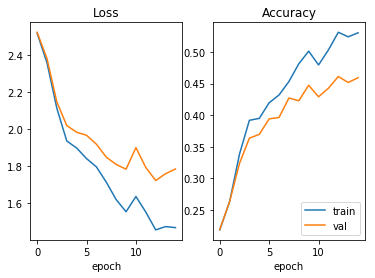

In [29]:
train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist = run.return_loss_acc()
val_loss_hist_scale = np.array(val_loss_hist)/np.shape(X_val)[0]
train_loss_hist_scale = np.array(train_loss_hist)/np.shape(X_train)[0]

f, (ax1, ax2) = plt.subplots(1,2)
ax1.set_title('Loss')
ax1.set_xlabel('epoch')
ax1.plot(train_loss_hist_scale, label = 'train')
ax1.plot(val_loss_hist_scale, label = 'val')

ax2.set_title('Accuracy')
ax2.plot(train_acc_hist, label = 'train')
ax2.plot(val_acc_hist, label = 'val')
ax2.set_xlabel('epoch')
ax2.legend(loc='lower right')


## Test Loading the Model

In [30]:
# Reset Graph
tf.reset_default_graph()
loader_address=r'./subreddit_classification_parameters/classification_model'

# Create model instance
model = AlexNet(config, learning_rate = 0.003)

# Load Saved Model
session = tf.Session()
saver = tf.train.Saver()
saver.restore(session, loader_address) 

# Test Model Accuracy
loss_train, acc_train = train_batch(session, model, data.X_train, data.Y_train, batch_size = 2000)
variables = [model.cost, model.accuracy]
loss_val, acc_val = session.run(variables, \
    {model.data:data.X_val, model.target:data.Y_val, model.is_training:False})

print('Training Accuracy {:3.1f}%, Vallidation Accuracy:{:3.1f}%'.format((100*acc_train), (100*acc_val)))

Training Accuracy 53.0%, Vallidation Accuracy:45.9%


## Output Predictions for Validation 

In [31]:
y_val_pred = session.run(model.prediction, {model.data: data.X_val, model.target: data.Y_val, model.is_training:False})

y_val_pred = np.argmax(y_val_pred, axis = 1)

## Plot Confusion Matrix for Subreddit Classification

Normalized confusion matrix


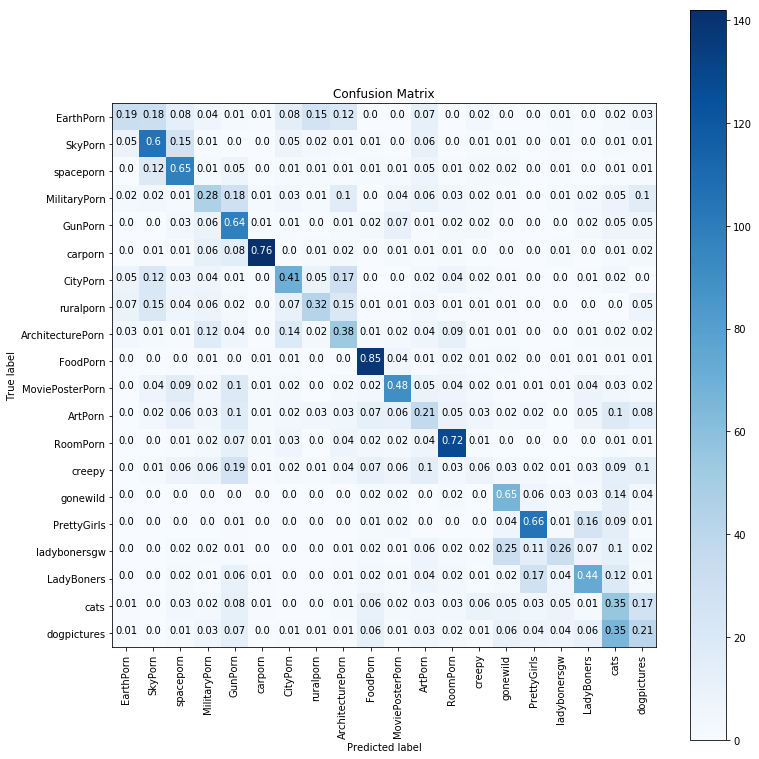

In [32]:
# Code to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues,
                          save_address = ''):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(11,11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    #plt.savefig(save_address + 'confusion_mat.png')

classes = [""] * len(dictionary)
for sub, ind in dictionary.items():
    classes[ind] = sub

conf = confusion_matrix(y_val, y_val_pred)
plot_confusion_matrix(conf, classes=classes, normalize = True)
